In [1]:
pip install sentencepiece

Note: you may need to restart the kernel to use updated packages.


In [3]:
from datasets import load_dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np
from tqdm import tqdm
from transformers import T5Tokenizer, T5ForConditionalGeneration
from sentence_transformers import SentenceTransformer
from peft import LoraConfig, get_peft_model, TaskType

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU available")
else:
    device = torch.device("cpu")
    print("GPU not available, using CPU")
    
# Load pre-trained models and tokenizers
t5_tokenizer = T5Tokenizer.from_pretrained('t5-base')
t5_model = T5ForConditionalGeneration.from_pretrained('t5-base')
sentence_transformer = SentenceTransformer('all-MiniLM-L6-v2')

GPU available


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## LoRA Configuration

In [6]:
lora_config = LoraConfig(r=16, 
                        lora_alpha=32, 
                        target_modules=["q", "v"], 
                        lora_dropout=0.05, 
                        bias="none", 
                        task_type="SEQ_2_SEQ_LM")

lora_model = get_peft_model(t5_model, lora_config)

def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

print_trainable_parameters(lora_model)

trainable params: 1769472 || all params: 224673024 || trainable%: 0.7875765272113843


## Data Preprocessing

In [7]:
dataset = load_dataset('ms_marco', 'v1.1')

train_data = dataset['train']
validation_data = dataset['validation']
test_data = dataset['test']

train_df = train_data.to_pandas()
train_df.drop(['query_id', 'query_type', 'wellFormedAnswers'], axis=1, inplace=True)
train_df = train_df[:50] # Limiting size

passage = []
answer = []

for i in range(len(train_df)):
    x = train_df['answers'][i].tolist()
    if len(x)==0:
        x = "-"
    passage.append((train_df['passages'][i]['passage_text']).tolist())
    answer.append(x[0])

train_df['passages'] = passage
train_df['answers'] = answer
train_df = train_df[['query', 'answers', 'passages']]
train_df.head()

,query,answers,passages
0,what is rba,Results-Based Accountability is a disciplined ...,"[Since 2007, the RBA's outstanding reputation ..."
1,was ronald reagan a democrat,Yes,"[In his younger years, Ronald Reagan was a mem..."
2,how long do you need for sydney and surroundin...,20-25 minutes,"[Sydney, New South Wales, Australia is located..."
3,price to install tile in shower,$11 to $22 per square foot,"[In regards to tile installation costs, consum..."
4,why conversion observed in body,Due to symptoms in the body,"[Conclusions: In adult body CT, dose to an org..."


In [8]:
unique_docs = []
for i in range(len(train_df)):
    x = train_df['passages'][i]
    for j in range(len(x)):
        unique_docs.append(x[j])
print(len(unique_docs))
unique_docs = list(set(unique_docs))

# Encode all docs
all_docs = unique_docs
doc_embeddings = sentence_transformer.encode(all_docs)

# Create FAISS index and store document embeddings
import faiss
index = faiss.IndexFlatIP(doc_embeddings.shape[1])
index.add(doc_embeddings)

unique_docs[:5]

413


['Enhancement and improvement costs. 1  Polished nickel faucets-Average cost is $400 each plus four hours of installation; 2  Install ceramic tile floor to match shower-Average prices for installation are between $11 to $22 per square foot; 3  A light/fan combination-Averages at $180 and one hour of installation; 4  Insulate and re-finish ceilings and 5  ... Painti',
 'There are more than 60 different species of opossum, which are often called possums. The most notable is the Virginia opossum or common opossum—the only marsupial (pouched mammal) found in the United States and Canada. A female opossum gives birth to helpless young as tiny as honeybees. ',
 'Our free calculator uses recent, trusted data to estimate costs for your Bathroom Floor Tile Installation project. For a basic 120 square feet project in zip code 47474, the benchmark cost to Install Bathroom Floor Tile ranges between $9.53 - $13.80 per square foot* .',
 'The effects of the eruption were felt worldwide. It ejected ro

## Batching

In [11]:
queries = train_df['query'].tolist()
answers = train_df['answers'].tolist()
k_value = 10 # Top 10 documents


query_embeddings = sentence_transformer.encode(queries)

# Create a list to store the inputs
inputs = []

for i in tqdm(range(len(queries)), desc="encoding query and finding top 10"):
    query = queries[i]
    answer = answers[i]
    query_embedding = query_embeddings[i]
    topk_doc_scores, topk_doc_indices = index.search(query_embedding.reshape(1, -1), k_value)
    top_docs = [all_docs[idx] for idx in topk_doc_indices[0]]
    topk_doc_scores = F.softmax(torch.tensor(topk_doc_scores[0]), dim=0) # finding top scores
    for j, doc_idx in enumerate(topk_doc_indices[0]):
        inputs.append((f"{query} {all_docs[doc_idx]}", answer, topk_doc_scores[j].item()))
        # print(inputs[j])
    
# Define custom dataset and dataloader
class QADataset(torch.utils.data.Dataset):
    def __init__(self, inputs):
        self.inputs = inputs

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx]

dataset = QADataset(inputs)
print(f"\ndataset is {dataset}")
for i, j, k in dataset:
    print(i)
    print(j)
    print(k)
    break

dataloader = torch.utils.data.DataLoader(dataset, batch_size=k_value, shuffle=False)
print(f"\ndataloader is {dataloader}")
for i, j, k in dataloader:
    print(i)
    print(j)
    print(k)
    break

torch.save(dataset, 'processed_dataset.pth')
print("\nDataset has been saved to 'processed_dataset.pth'")

encoding query and finding top 10: 100%|██████████| 50/50 [00:00<00:00, 5363.83it/s]


dataset is <__main__.QADataset object at 0x7f5151514790>
what is rba Get To Know Us. RBA is a digital and technology consultancy with roots in strategy, design and technology. Our team of specialists help progressive companies deliver modern digital experiences backed by proven technology engineering. 
Results-Based Accountability is a disciplined way of thinking and taking action that communities can use to improve the lives of children, youth, families, adults and the community as a whole.
0.1244548037648201

dataloader is <torch.utils.data.dataloader.DataLoader object at 0x7f511dacead0>
('what is rba Get To Know Us. RBA is a digital and technology consultancy with roots in strategy, design and technology. Our team of specialists help progressive companies deliver modern digital experiences backed by proven technology engineering. ', 'what is rba RBA Recognized with the 2014 Microsoft US Regional Partner of the ... by PR Newswire. Contract Awarded for supply and support the. Securit

In [13]:
# Load the dataset
dataset = torch.load('/workspace/RAG/RAG/processed_dataset.pth')
# Recreate the DataLoader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=k_value, shuffle=False)

randy = 0
for i,j,k in dataloader:
    if randy == 156:
        print(i)
        print(j)
        print(k)
        print(k.sum(dim = 0 , keepdims = True))
        break
    randy +=1

len(dataloader)

50

## Model

In [16]:
import os
class QAModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.t5 = lora_model

    def forward(self, input_ids, attention_mask, decoder_input_ids, labels=None):
        outputs = self.t5(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_input_ids=decoder_input_ids,  #causal mask is handled internally
            labels=labels)
        return outputs

model = QAModel()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
epochs = 20

save_path = '/workspace/RAG/'
checkpoint_path = os.path.join(save_path, 'small_model.pth')
os.makedirs(save_path, exist_ok=True)

model.to(device)

QAModel(
  (t5): PeftModelForSeq2SeqLM(
    (base_model): LoraModel(
      (model): T5ForConditionalGeneration(
        (shared): Embedding(32128, 768)
        (encoder): T5Stack(
          (embed_tokens): Embedding(32128, 768)
          (block): ModuleList(
            (0): T5Block(
              (layer): ModuleList(
                (0): T5LayerSelfAttention(
                  (SelfAttention): T5Attention(
                    (q): lora.Linear(
                      (base_layer): Linear(in_features=768, out_features=768, bias=False)
                      (lora_dropout): ModuleDict(
                        (default): Dropout(p=0.05, inplace=False)
                      )
                      (lora_A): ModuleDict(
                        (default): Linear(in_features=768, out_features=16, bias=False)
                      )
                      (lora_B): ModuleDict(
                        (default): Linear(in_features=16, out_features=768, bias=False)
                      )
         

## Training

In [17]:
our_loss = []
model_loss = []

max_batches_per_epoch = 50 

for epoch in range(epochs):
    epoch_loss = 0.0
    epoch_model_loss = 0.0
    batch_count = 0 

    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch + 1}/{epochs}", leave=False)
    
    for inputs, answer, score in progress_bar:
        if batch_count >= max_batches_per_epoch:
            break  # Stop processing after max_batches_per_epoch batches

        # Tokenize and move inputs to GPU
        inputs_dict = t5_tokenizer(inputs, return_tensors='pt', padding=True, truncation=True, max_length=512)
        input_ids = inputs_dict['input_ids'].to(device)
        attention_mask = inputs_dict['attention_mask'].to(device)

        # Tokenize and move answers to GPU
        answer_dict = t5_tokenizer(answer, return_tensors='pt', padding=True, truncation=True, max_length=512)
        answer_dict_ids = answer_dict['input_ids'].to(device)
        decoder_inputs = answer_dict_ids[:, :-1].contiguous()
        labels = answer_dict_ids[:, 1:].contiguous()

        # Ensure score tensor is on GPU
        score = score.to(device).unsqueeze(1).unsqueeze(2)

        # Forward pass
        outputs = model(input_ids, attention_mask, decoder_inputs, labels=labels)  # causal mask is handled internally
        softmaxed_logits = torch.nn.functional.softmax(outputs.logits, dim=2)
        final = score * softmaxed_logits
        final_result = final.sum(dim=0, keepdim=True)

        # Compute custom loss
        predictions = final_result.view(-1, final_result.size(-1))
        flat_labels = decoder_inputs[0].view(-1)
        loss = torch.nn.functional.cross_entropy(predictions, flat_labels)

        epoch_loss += loss.item()
        epoch_model_loss += outputs.loss.item()

        # Backward and optimize
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Update progress bar and batch count
        progress_bar.set_description(f"Epoch {epoch + 1}/{epochs} - Loss: {loss.item():.4f}")
        batch_count += 1

    # Save the model state at the end of the epoch
    torch.save({'optimizer_state_dict': optimizer.state_dict()}, checkpoint_path)
    
    # Record and print average losses for the epoch
    our_loss.append(epoch_loss / max_batches_per_epoch)
    model_loss.append(epoch_model_loss / max_batches_per_epoch)
    print(f"Epoch {epoch + 1}/{epochs} - Our Loss: {epoch_loss / max_batches_per_epoch:.4f}")
    # print(f"Epoch {epoch + 1}/{epochs} - Model Loss: {epoch_model_loss / max_batches_per_epoch:.4f}")

Epoch 1/20 - Our Loss: 10.3047


Epoch 2/20 - Our Loss: 10.3010


Epoch 3/20 - Our Loss: 10.2966


Epoch 4/20 - Our Loss: 10.2913


Epoch 5/20 - Our Loss: 10.2856


Epoch 6/20 - Our Loss: 10.2801


Epoch 7/20 - Our Loss: 10.2747


Epoch 8/20 - Our Loss: 10.2691


Epoch 9/20 - Our Loss: 10.2633


Epoch 10/20 - Our Loss: 10.2575


Epoch 11/20 - Our Loss: 10.2516


Epoch 12/20 - Our Loss: 10.2454


Epoch 13/20 - Our Loss: 10.2389


Epoch 14/20 - Our Loss: 10.2318


Epoch 15/20 - Our Loss: 10.2245


Epoch 16/20 - Our Loss: 10.2171


Epoch 17/20 - Our Loss: 10.2100


Epoch 18/20 - Our Loss: 10.2029


Epoch 19/20 - Our Loss: 10.1959


Epoch 20/20 - Our Loss: 10.1887


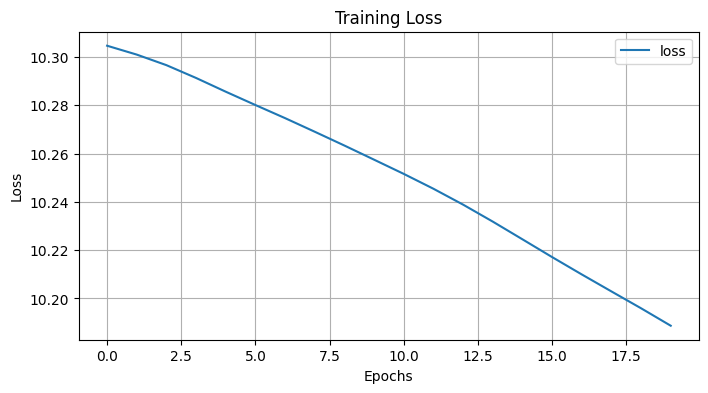

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))  
plt.plot(our_loss,label='loss')
# plt.plot(model_loss, label='new_loss')  
plt.title('Simple Line Plot')  
plt.xlabel('Epochs')  
plt.ylabel('Loss')
plt.title("Training Loss")
plt.legend()  
plt.grid(True) 
plt.show()

## Inference

In [28]:
class QAModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.t5 = lora_model

    def forward(self, input_ids, attention_mask, decoder_input_ids, labels=None):
        outputs = self.t5(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_input_ids=decoder_input_ids,  #causal mask is handled internally
            labels=labels)
        return outputs

model = QAModel()
model.load_state_dict(torch.load('/workspace/RAG/small_trained.pth'))
model.eval()
model.to(device)

QAModel(
  (t5): PeftModelForSeq2SeqLM(
    (base_model): LoraModel(
      (model): T5ForConditionalGeneration(
        (shared): Embedding(32128, 768)
        (encoder): T5Stack(
          (embed_tokens): Embedding(32128, 768)
          (block): ModuleList(
            (0): T5Block(
              (layer): ModuleList(
                (0): T5LayerSelfAttention(
                  (SelfAttention): T5Attention(
                    (q): lora.Linear(
                      (base_layer): Linear(in_features=768, out_features=768, bias=False)
                      (lora_dropout): ModuleDict(
                        (default): Dropout(p=0.05, inplace=False)
                      )
                      (lora_A): ModuleDict(
                        (default): Linear(in_features=768, out_features=16, bias=False)
                      )
                      (lora_B): ModuleDict(
                        (default): Linear(in_features=16, out_features=768, bias=False)
                      )
         

In [30]:
inputs = []

def generate_answer(query, starting_word):
    # Generate the query embedding
    query_embedding = sentence_transformer.encode([query])

    # Retrieve top-k documents using FAISS
    topk_doc_scores, topk_doc_indices = index.search(query_embedding, k_value)
    topk_doc_scores = F.softmax(torch.tensor(topk_doc_scores[0]), dim=0)
    top_docs = [all_docs[idx] for idx in topk_doc_indices[0]]
    print(topk_doc_scores)
    print(topk_doc_scores.sum(dim=0))

    for j, doc_idx in enumerate(topk_doc_indices[0]):
        inputs.append((f"{query} {all_docs[doc_idx]}", starting_word, topk_doc_scores[j].item()))
        # print(inputs[j])
    return inputs

query = "translate English to French: What is the capital of Australia?"
starting_word = "Sydney hello hello world"
ending_word = "</sos>"
max_length = 50
generated_sequence = generate_answer(query, starting_word)
print(len(generated_sequence))

dataset = QADataset(generated_sequence)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=k_value, shuffle=False)
print(f"\ndataloader is {dataloader}")
for i, j, k in dataloader:
    print(i)
    print(j)
    print(k)
    print(k.sum(dim=0))
    break

tensor([0.1176, 0.1089, 0.1023, 0.1005, 0.1000, 0.0967, 0.0942, 0.0939, 0.0931,
        0.0929])
tensor(1.)
10

dataloader is <torch.utils.data.dataloader.DataLoader object at 0x7f5098328970>
("translate English to French: What is the capital of Australia? Sydney is the capital city of the Australian state of New South Wales, and Australia's largest city. A week in Sydney will help you see many of the sights of Sydney and its surrounds, and understand the city and its culture. If you're up for exploring the area by bike (one of the best ways to do so as much of it is parkland), take the train to Concord West station on the Northern Line (red line on the Sydney Trains map-about 20-25 minutes from the city on a direct train).", 'translate English to French: What is the capital of Australia? Sydney, New South Wales, Australia is located in a coastal basin bordered by the Pacific Ocean to the east, the Blue Mountains to the west, the Hawkesbury River to the north and the Woronora Plateau t

In [24]:
progress_bar = tqdm(dataloader, desc=f"Epoch {epoch + 1}/{epochs}", leave=False)

for inputs, answer, score in progress_bar:

        # Tokenize and move inputs to GPU
        inputs_dict = t5_tokenizer(inputs, return_tensors='pt', padding=True, truncation=True, max_length=512)
        input_ids = inputs_dict['input_ids'].to(device)
        attention_mask = inputs_dict['attention_mask'].to(device)

        print(f"\ninput_ids are {input_ids.shape}\n{input_ids}")
        print(f"input attention_mask are {attention_mask.shape}\n{attention_mask}")

        # Tokenize and move answers to GPU
        answer_dict = t5_tokenizer(answer, return_tensors='pt', padding=True, truncation=True, max_length=512)
        answer_dict_ids = answer_dict['input_ids'].to(device)
        decoder_inputs = answer_dict_ids[:, :-1].contiguous()

        print(f"\nanswer_dict_ids are {answer_dict_ids.shape}")
        print(f"decoder_inputs are {decoder_inputs.shape}")

        # Ensure score tensor is on GPU
        score = score.to(device).unsqueeze(1).unsqueeze(2)
        print(f"\nscore is {score.shape}")

        # Forward pass
        outputs = model(input_ids, attention_mask, decoder_inputs)
        print(outputs.keys())

        print(f"\noutputs is {outputs['logits'].shape}")
        softmaxed_logits = torch.nn.functional.softmax(outputs.logits, dim=2)
        print(f"\nsoftmaxed_logits are {softmaxed_logits.shape}")
        print(f"\nThe sum of 1st row is {softmaxed_logits[0, 0].sum()}")
        final = score * softmaxed_logits
        print(f"\nAfter multiplied to softmax are {final.shape}")
        final_result = final.sum(dim=0, keepdim=True)
        print(f"\nAfter summed are {final_result.shape}")
        print(f"\nThe sum of 1st row is {final_result[0, 0].sum()}")
        predicted_token = torch.argmax(final_result, dim=-1)
        print(f"\npredicted_token is {predicted_token}")
        predicted_word = t5_tokenizer.decode(predicted_token[-1])
        print(f"predicted_word is {predicted_word}")
        print("-" * 50)


input_ids are torch.Size([10, 158])
tensor([[13959,  1566,    12,  ...,     0,     0,     0],
        [13959,  1566,    12,  ...,     0,     0,     0],
        [13959,  1566,    12,  ...,     0,     0,     0],
        ...,
        [13959,  1566,    12,  ...,     0,     0,     0],
        [13959,  1566,    12,  ...,     0,     0,     0],
        [13959,  1566,    12,  ...,     0,     0,     0]], device='cuda:0')
input attention_mask are torch.Size([10, 158])
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0')

answer_dict_ids are torch.Size([10, 5])
tensor([[ 7476, 21820, 21820,   296,     1],
        [ 7476, 21820, 21820,   296,     1],
        [ 7476, 21820, 21820,   296,     1],
        [ 7476, 21820, 21820,   296,     1],
        [ 7476, 21820, 21820,   296,     1],
        [ 7476, 21820, 21820,   296,

## Language translation

In [32]:
class PeftModelForSeq2SeqLM(nn.Module):
    def generate(self, input_ids, max_length=20, **kwargs):
        # Your implementation here, possibly calling the base generate with necessary arguments
        return super().generate(input_ids, max_length=max_length, **kwargs)


query = "translate English to French: hello are you?"
input_ids = t5_tokenizer.encode(query, return_tensors="pt").to(device)  # Convert query to input IDs and transfer to appropriate device

# Generate the output IDs from the model
output_ids = lora_model.base_model.generate(input_ids, max_length=50)


# Decode the output IDs to a string
output_text = t5_tokenizer.decode(output_ids[0], skip_special_tokens=True)
print(output_text)


Bonjour, êtes-vous?


In [18]:
t5_tokenizer.decode(3)

''